<a href="https://colab.research.google.com/github/tnnandi/RNN-MDN/blob/master/LSTM_MDN_stateful_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
import numpy as np
np.random.seed(0)

input_file = 'CpLongDataAll_tap90.txt'
#input_file = '/content/drive/My Drive/CpLongDataAll_tap90B.txt'
import pandas as pd

data = pd.read_csv(input_file, sep='\t', header=None)

In [0]:
Y = data.values.reshape(144000*28,1)
#X = Y[1*144000:194000]
X = Y[1*144000:2*144000]

In [0]:
from sklearn.preprocessing import MaxAbsScaler, RobustScaler, StandardScaler, MinMaxScaler

scaler_train = StandardScaler()
#scaler_train = MinMaxScaler(feature_range=(0,1))
X = scaler_train.fit_transform(X)

In [618]:
import numpy as np
np.shape(X)

(144000, 1)

In [619]:
np.mean(X), np.std(X)

(-8.684411214845669e-18, 1.0)

In [0]:
# List all hyperparameters
from keras.optimizers import RMSprop, Adam

# Length of extracted time sequences
maxlen = 450#50

# We sample a new sequence every `step` time-step
# For stateful sequences, step should be equal to maxlen, as all sequences need to be non-overlapping (also in order, set "Shuffle=False" in model.fit)
step = 1#maxlen

# Number of Gaussian Mixtures
n_mix = 15

# Batch size
batch_size = 4785#99#2870#1435    #4950#5500

#Optimizer
optimizer = RMSprop(lr=0.001, decay=0.0)

In [621]:
# This holds our extracted sequences
sequences = []

# This holds the targets (the follow-up value)
next_vals = []

for i in range(0, len(X) - maxlen, step):
    sequences.append(X[i: i + maxlen])
    next_vals.append(X[i + maxlen])

print("size of training data: ", len(X))    
print("Window size for time series forecasting: ", maxlen)
print('Number of sequences:', len(sequences))



size of training data:  144000
Window size for time series forecasting:  450
Number of sequences: 143550


In [0]:
x = sequences
y = next_vals

In [0]:
#x, np.shape(x)

In [0]:
from keras import layers
from keras.models import Sequential
from keras.optimizers import RMSprop, Adam

# Format for LSTM layer: keras.layers.LSTM(units,  )
# units: dimensionality of the output space

# Define the model
model = Sequential()
#model.add(layers.LSTM(128, return_sequences = True, input_shape=(maxlen, 1)))
model.add(layers.LSTM(64, return_sequences = True, stateful = 'True', batch_size = batch_size, input_shape=(maxlen, 1), name='LSTM1'))
model.add(layers.LSTM(64, return_sequences = True, stateful = 'True', input_shape=(maxlen, 1), name='LSTM2'))
model.add(layers.Flatten(name='Flatten')) # Added to make the final dense layer input shape compatible with the output of LSTM with "return_sequence=True"
#model.add(layers.Dense(1, activation='sigmoid'))
model.add(layers.Dense(16, activation='sigmoid'))
model.add(layers.Dense(3*n_mix, activation='linear', name='DenseFinal'))

In [625]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (4785, 450, 64)           16896     
_________________________________________________________________
LSTM2 (LSTM)                 (4785, 450, 64)           33024     
_________________________________________________________________
Flatten (Flatten)            (4785, 28800)             0         
_________________________________________________________________
dense_25 (Dense)             (4785, 16)                460816    
_________________________________________________________________
DenseFinal (Dense)           (4785, 45)                765       
Total params: 511,501
Trainable params: 511,501
Non-trainable params: 0
_________________________________________________________________


Katnoria: In MDNs, instead of modeling the input (x) -> target (y) mapping by explicitly generating the output values,
we learn the probability distribution of EACH TARGET and sample the PREDICTED OUTPUT \hat{y} 
yHat from that distribution.

In [0]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
from keras import backend as K
 
  
def mdn_loss(target, dense_output):
    """MDN Loss Function
    The eager mode in tensorflow 2.0 makes is extremely easy to write 
    functions like these. It feels a lot more pythonic to me.
    """
   

    mu_tmp = dense_output[:,:n_mix]   # CHECK these sizes
    sigma_tmp = dense_output[:, n_mix:2*n_mix]
    pi_tmp = dense_output[:, 2*n_mix:]    

    
    mu = mu_tmp
    sigma = tf.exp(sigma_tmp/2.0) # Standard deviation
    pi = tf.nn.softmax(pi_tmp)
    
    # find the likelihood of target from each mixture 
    out = tfd.Normal(mu, sigma).prob(tf.reshape(target,(-1,1)))
    # multiply with each pi and sum it
    out = tf.multiply(out, pi)
    out = tf.reduce_sum(out, 1, keepdims=True)
    out = -tf.math.log(out + 1e-10)
    out = tf.reduce_mean(out)
    #out = tf.reduce_mean(np.square(dense_output - target),axis=0)
    return out

In [0]:
model.compile(loss=mdn_loss, optimizer=optimizer)


In [628]:
np.shape(np.array(x)), np.shape(np.array(y))

((143550, 450, 1), (143550, 1))

In [0]:
# updatable plot
# a minimal example (sort of)
import keras

class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        #clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
# Recreate the exact same model, including weights and optimizer.
# import keras
# new_model = keras.models.load_model('savedModel.01.hdf5', custom_objects={'mdn_loss':mdn_loss})
# new_model.summary()
# batch_size = 4785

epoch =  0
Epoch 1/1
 - 69s - loss: 0.0496


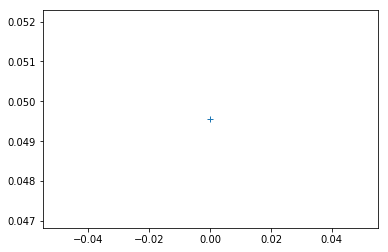

epoch =  1
Epoch 1/1
 - 68s - loss: 0.0474


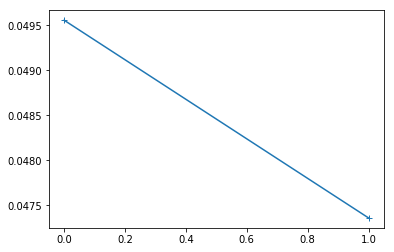

epoch =  2
Epoch 1/1
 - 68s - loss: 0.0369


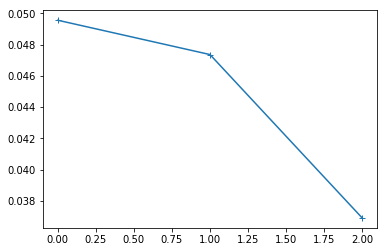

epoch =  3
Epoch 1/1
 - 68s - loss: 0.0326


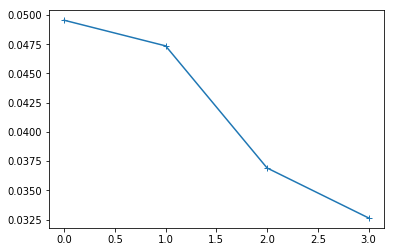

epoch =  4
Epoch 1/1
 - 68s - loss: 0.0325


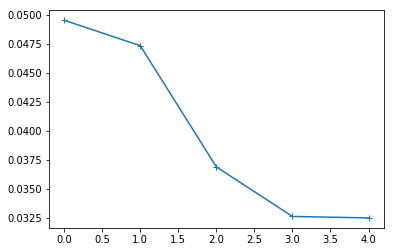

epoch =  5
Epoch 1/1
 - 68s - loss: 0.0199


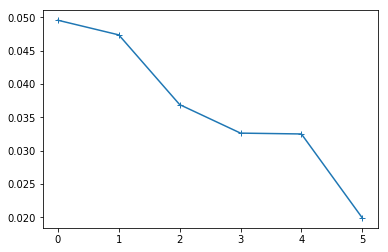

epoch =  6
Epoch 1/1
 - 68s - loss: 0.0167


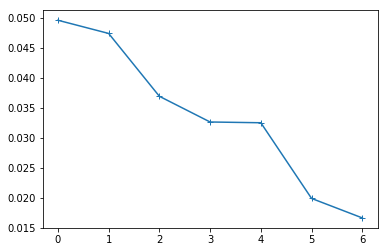

epoch =  7
Epoch 1/1
 - 68s - loss: 0.0057


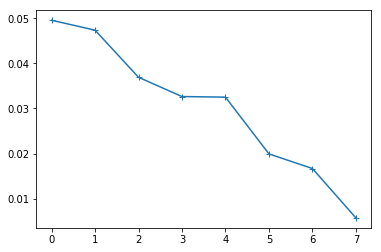

epoch =  8
Epoch 1/1
 - 68s - loss: 0.0025


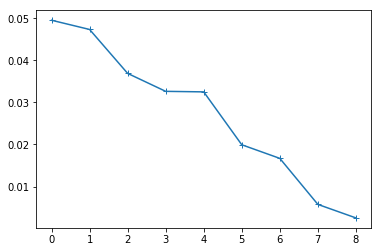

epoch =  9
Epoch 1/1
 - 68s - loss: -7.3732e-03


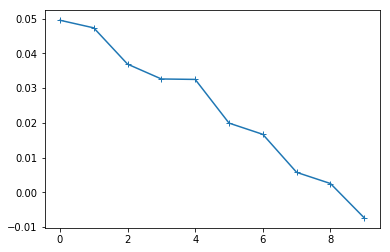

epoch =  10
Epoch 1/1
 - 68s - loss: -1.6040e-02


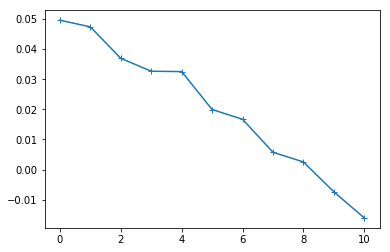

epoch =  11
Epoch 1/1
 - 68s - loss: -2.2009e-02


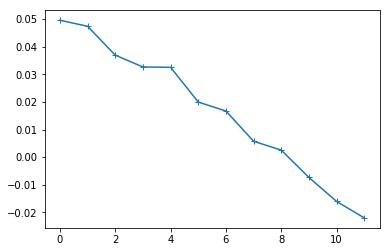

epoch =  12
Epoch 1/1
 - 68s - loss: -2.5934e-02


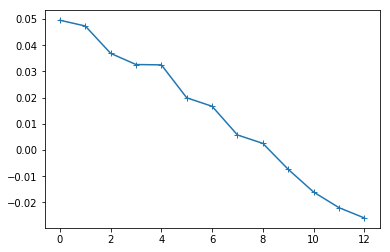

epoch =  13
Epoch 1/1
 - 68s - loss: -3.3317e-02


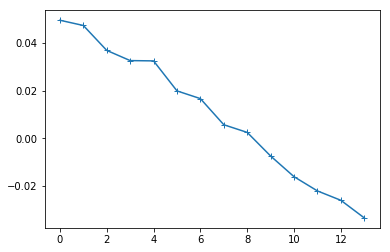

epoch =  14
Epoch 1/1
 - 68s - loss: -5.3987e-02


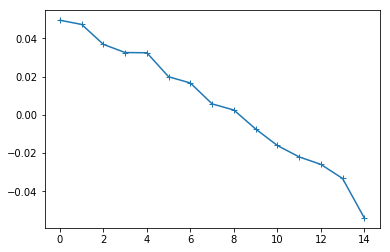

epoch =  15
Epoch 1/1
 - 68s - loss: -4.5473e-02


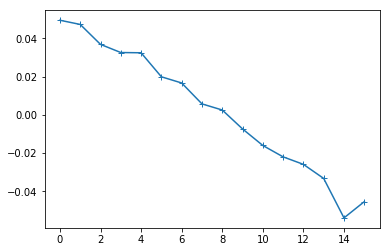

epoch =  16
Epoch 1/1
 - 68s - loss: -5.9048e-02


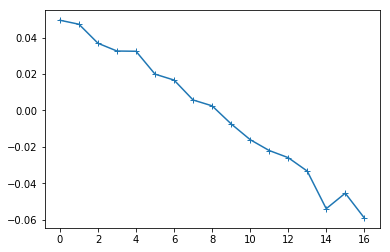

epoch =  17
Epoch 1/1
 - 68s - loss: -6.7067e-02


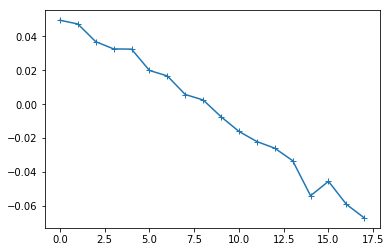

epoch =  18
Epoch 1/1
 - 68s - loss: -8.7872e-02


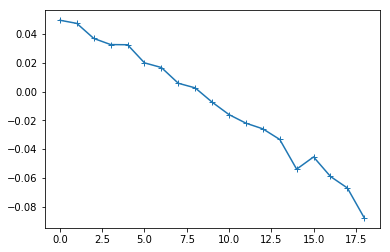

epoch =  19
Epoch 1/1
 - 68s - loss: -7.7201e-02

Epoch 00001: saving model to savedModel.01.hdf5


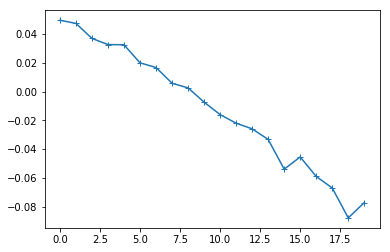

In [715]:
#https://keras.io/getting-started/faq/
import matplotlib.pyplot as plt
%matplotlib inline

num_epochs = 20

saveModel = keras.callbacks.ModelCheckpoint(
                                            'savedModel.{epoch:02d}.hdf5', monitor='val_loss', verbose=1, save_best_only=False, 
                                             save_weights_only=False, mode='auto', period=20)

epochLossAll = []
for i in range(num_epochs):
  print("epoch = ", i)
  history = model.fit(np.array(x), np.array(y),
              #batch_size=256,
              shuffle=False, # Critical for stateful LSTM
              batch_size=batch_size, # try as large as possible before going out of memory
              epochs=1,
              verbose = 2,
              callbacks=[saveModel])
  epochLossAll.append(history.history['loss'])
  plt.plot(epochLossAll, '-+')  
  plt.show()
  model.reset_states()



In [0]:
# import keras
# model = keras.models.load_model('savedModel.01.hdf5', custom_objects={'mdn_loss':mdn_loss})
# model.summary()

In [716]:
model.get_layer('DenseFinal')

In [717]:
# View the output Gaussian mixtures. Get the output from the final dense layer
from keras.models import Model

layer_name = 'DenseFinal'
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(np.array(x), batch_size = batch_size)

print(intermediate_output)
# model.summary()
# finalLayer_output = Model.get_layer('DenseFinal').output
# #W = np.squeeze(W)
# m = model(inputs=model.input, outputs=finalLayer_output)
# print(m.predict(np.array(x)))

[[-1.3069286  -0.5765357  -0.4287493  ... -2.6975508  -1.999862
   1.6090169 ]
 [-0.9504551  -0.33253345  0.10631114 ... -2.5476055  -1.8251004
   1.2715068 ]
 [-1.7461448  -0.71601355 -0.41659585 ... -2.551395   -1.8734418
   1.4052539 ]
 ...
 [ 0.0060319  -0.20390755  0.3241288  ... -2.033558   -1.7574117
   1.0941559 ]
 [ 0.07785922 -0.16067019  0.16316316 ... -1.9941366  -1.7361296
   1.3617855 ]
 [ 0.18203092 -0.28848147  0.22242656 ... -2.5794392  -2.3201976
   1.5508612 ]]


In [718]:
np.shape(intermediate_output)

(143550, 45)

In [0]:
import matplotlib.pyplot as plt
#plt.plot(intermediate_output[-2000,:], '+')
output = intermediate_output[-1,:]

In [0]:
#output = model.predict(np.array(x), batch_size = 256, verbose = 1)

In [721]:
np.shape(output)

(45,)

In [0]:
#plt.plot(output[:,:])

In [0]:
from scipy.special import softmax
mu_tmp = output[:n_mix]
sigma_tmp = output[n_mix:2*n_mix]
pi_tmp = output[2*n_mix:]

mu = mu_tmp
sigma = np.exp(sigma_tmp/2.0)
#sigma = np.abs(sigma_tmp)
pi = softmax(pi_tmp)


In [724]:
mu_tmp, sigma_tmp, pi_tmp

(array([ 0.18203092, -0.28848147,  0.22242656,  0.0501624 ,  0.1853769 ,
        -0.40969247, -0.03306395, -0.47188875,  0.45549712, -0.37213573,
        -0.29316202,  0.53446037,  0.13751894, -0.34497494,  0.06985439],
       dtype=float32),
 array([-2.6955197, -3.7397106, -5.485825 , -3.5291965, -3.8667188,
        -2.2477286, -4.8490534,  0.6026172, -4.43835  , -1.4822409,
        -1.8798003, -2.7798364, -4.084592 , -1.77736  , -4.364755 ],
       dtype=float32),
 array([-2.1202593 , -0.80333984,  0.87294465, -1.8229773 , -3.9003527 ,
        -2.274098  ,  2.283035  , -3.917693  , -1.8867526 , -2.8115685 ,
        -1.7321429 , -4.4076347 , -2.5794392 , -2.3201976 ,  1.5508612 ],
       dtype=float32))

([<matplotlib.lines.Line2D at 0x7f9516be7ef0>], 0.00010117741048509237)

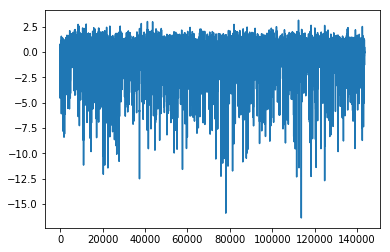

In [725]:
plt.plot(y), np.mean(y)

In [726]:
np.shape(X), np.shape(y)

((144000, 1), (143550, 1))

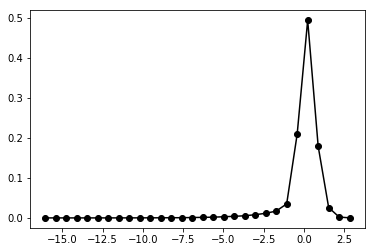

In [727]:
def plotPdf(data, nBins):
  heights_all,bins_all = np.histogram(data, bins=nBins)
  # Normalize and get the pdf
  heights_all = heights_all/float(sum(heights_all))
  binMids_all=bins_all[:-1]+np.diff(bins_all)/2.
  return heights_all, binMids_all

heights_real, binMids_real = plotPdf(X, 30)

plt.plot(binMids_real,heights_real, 'k-o')

In [728]:
np.shape(mu)

(15,)

In [729]:
mu, sigma,pi

(array([ 0.18203092, -0.28848147,  0.22242656,  0.0501624 ,  0.1853769 ,
        -0.40969247, -0.03306395, -0.47188875,  0.45549712, -0.37213573,
        -0.29316202,  0.53446037,  0.13751894, -0.34497494,  0.06985439],
       dtype=float32),
 array([0.25982165, 0.15414597, 0.06438256, 0.17125557, 0.14466141,
        0.3250214 , 0.08852001, 1.3516264 , 0.10869874, 0.47657964,
        0.39066684, 0.24909568, 0.12973052, 0.4111982 , 0.11277308],
       dtype=float32),
 array([0.00653487, 0.02438753, 0.13036741, 0.00879721, 0.00110193,
        0.00560307, 0.5340274 , 0.00108298, 0.00825368, 0.00327345,
        0.00963372, 0.0006635 , 0.00412874, 0.00535063, 0.25679377],
       dtype=float32))

In [0]:
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
import scipy.stats as stats


# #xx = np.linspace(mu[0] - 3*sigma[0], mu[0] + 3*sigma[0], 100)
# xx = np.linspace(-4,2,1000)
# plt.plot(xx, stats.norm.pdf(xx, mu[0], sigma[0]))
# plt.show()



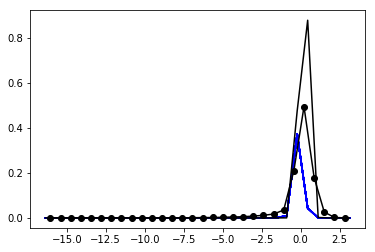

In [731]:
nPoints = 30

xx = np.linspace(min(X),max(X),nPoints)

pdf = np.zeros([nPoints,])
for i in range(n_mix-1):
  pdf = pdf + pi[i]*stats.norm.pdf(xx, mu[i], sigma[i])
  
plt.plot(xx,pdf, 'b')
plt.plot(xx, stats.norm.pdf(xx, mu[0], sigma[0]), 'k') # Uses the GMM parameters after the first epoch
plt.plot(binMids_real,heights_real, 'k-o')
  

(-5, 3)

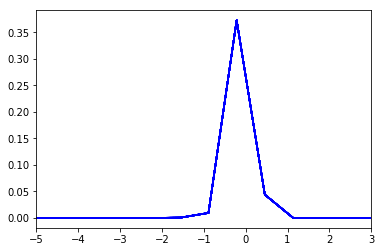

In [732]:
plt.plot(xx,pdf, 'b')
plt.xlim([-5,3])

In [0]:
# plt.semilogy(xx,pdf, 'b')
# #plt.semilogy(xx, stats.norm.pdf(xx, mu[0], sigma[0]), 'k')
# plt.semilogy(binMids_real,heights_real, 'k-o')

In [0]:
#heights_real, pdf

In [762]:
np.min(y), np.mean(y), np.max(y)

(-16.376724597333226, 0.00010117741048509237, 3.1505638032708845)

In [0]:
model.save("test.h5")
print("Model saved")

In [0]:
# from google.colab import files
# files.download('fruits.h5')

In [0]:
# Recreate the exact same model, including weights and optimizer.
import keras
new_model = keras.models.load_model('test.h5', custom_objects={'mdn_loss':mdn_loss})
new_model.summary()

In [0]:
#Predict the LSTM network output
preds = model.predict(np.array(x), verbose=1, batch_size=batch_size)

In [0]:
np.shape(preds)

In [0]:
test = np.random.uniform()
print(test)

# Generate a sequence from a seed value
1. Draw the first sample from a uniform distribution.
2. Choose the next sample from the Gaussian mixtures.
3. Append it to the 

([<matplotlib.lines.Line2D at 0x7f9516a72da0>], -8.684411214845669e-18, 1.0)

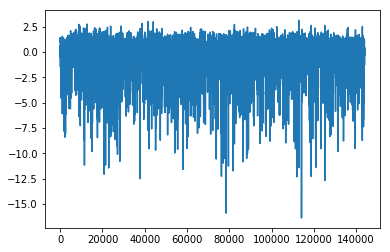

In [736]:
plt.plot(X), np.mean(X), np.std(X)

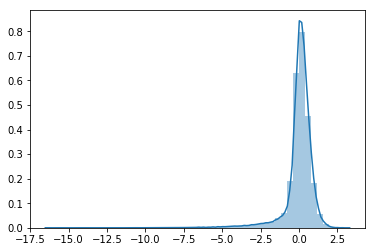

In [737]:
import seaborn as sns

sns.distplot(X)

In [738]:
mu, sigma, pi

(array([ 0.18203092, -0.28848147,  0.22242656,  0.0501624 ,  0.1853769 ,
        -0.40969247, -0.03306395, -0.47188875,  0.45549712, -0.37213573,
        -0.29316202,  0.53446037,  0.13751894, -0.34497494,  0.06985439],
       dtype=float32),
 array([0.25982165, 0.15414597, 0.06438256, 0.17125557, 0.14466141,
        0.3250214 , 0.08852001, 1.3516264 , 0.10869874, 0.47657964,
        0.39066684, 0.24909568, 0.12973052, 0.4111982 , 0.11277308],
       dtype=float32),
 array([0.00653487, 0.02438753, 0.13036741, 0.00879721, 0.00110193,
        0.00560307, 0.5340274 , 0.00108298, 0.00825368, 0.00327345,
        0.00963372, 0.0006635 , 0.00412874, 0.00535063, 0.25679377],
       dtype=float32))

In [739]:
np.shape(X)

(144000, 1)

In [0]:
# Create similar model as the trained one to avoid using the same batch_size

# re-define the batch size
batch_size_new = 1


# re-define model
new_model = Sequential()
new_model.add(layers.LSTM(64, return_sequences = True, stateful = 'False', batch_size = batch_size_new, input_shape=(maxlen, 1), name='LSTM1'))
new_model.add(layers.LSTM(64, return_sequences = True, stateful = 'False', input_shape=(maxlen, 1), name='LSTM2'))
new_model.add(layers.Flatten(name='Flatten')) # Added to make the final dense layer input shape compatible with the output of LSTM with "return_sequence=True"
new_model.add(layers.Dense(16, activation='sigmoid'))
new_model.add(layers.Dense(3*n_mix, activation='linear', name='DenseFinal'))

# copy weights
old_weights = model.get_weights()
new_model.set_weights(old_weights)

In [0]:
import scipy

seq = []
seq.append(np.random.uniform())
seq = X[:maxlen] # Use this as the seed

seq_len = 5000

for step in range(seq_len):
  print("step = ", step)
  #print("shape of preds = ", np.shape(preds))
  LSTM_input = seq[-maxlen:] # Extract only the last "maxlen" values for LSTM input
  print("shape(LSTM_input) = ", np.shape(LSTM_input))
  LSTM_input = np.reshape(LSTM_input, ([-1, maxlen, 1]))
  pred = new_model.predict(LSTM_input, batch_size=1)
  #print(np.shape(pred))
  mu = pred[:, :n_mix]
  sigma = pred[:, n_mix:2*n_mix]
  pi = pred[:, 2*n_mix:]

  mu = np.squeeze(mu)
  sigma = np.squeeze(sigma)
  pi = np.squeeze(pi)
  
  sigma = np.exp(sigma/2.0) # Standard deviation
  pi = scipy.special.softmax(pi)
  #print("sigma = ", sigma)
  #print(type(n_mix))
  #print(type(pi))
  select_mixture = np.random.choice(n_mix, p=pi)
  print("mixture component selected = ", select_mixture)
  new_pred = np.random.normal(loc=mu[select_mixture], scale= sigma[select_mixture])
  print(new_pred)
  #scale = sigma[select_mixture]
  # print(np.shape(seq))
  # print(np.shape(new_pred))
  # print(type(seq))
  # print(seq)
  # print(new_pred)
  # Append the newly predicted value to the end of the seq array
  seq = np.append(np.squeeze(seq), new_pred)
  print("shape of generated sequence: ", np.shape(seq))
  

In [0]:
gen_seq = seq[maxlen:]

(-11, 2)

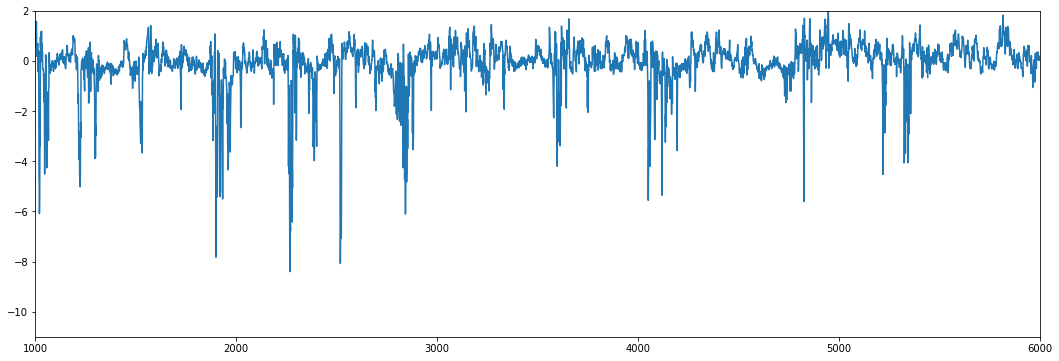

In [755]:
plt.figure(figsize=(18, 6))
plt.plot(X)
plt.xlim([1000,6000])
plt.ylim([-11,2])

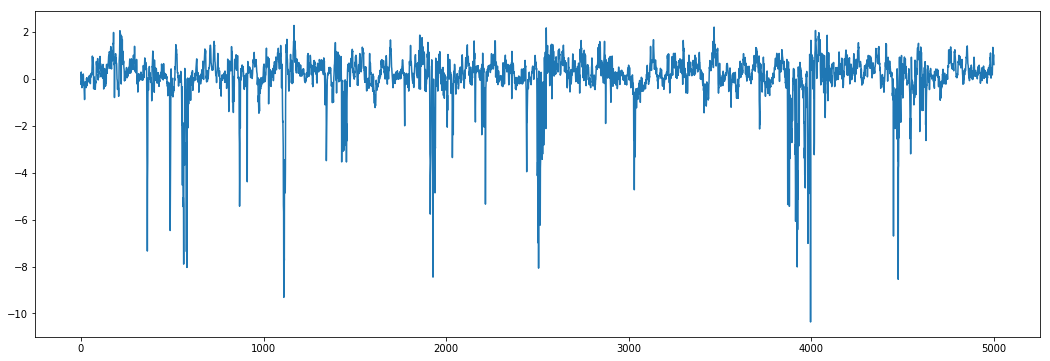

In [744]:
plt.figure(figsize=(18, 6))
plt.plot(gen_seq)
#plt.xlim([200,400])

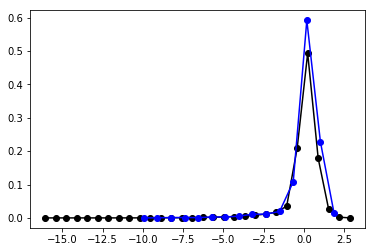

In [759]:
heights_synthetic, binMids_synthetic = plotPdf(gen_seq, 15)

plt.plot(binMids_real,heights_real, 'k-o')
plt.plot(binMids_synthetic,heights_synthetic, 'b-o')


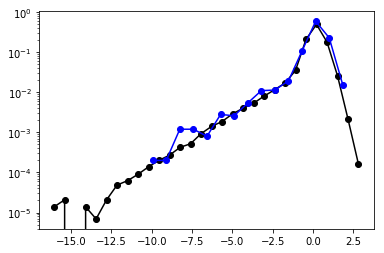

In [760]:
plt.semilogy(binMids_real,heights_real, 'k-o')
plt.semilogy(binMids_synthetic,heights_synthetic, 'b-o')

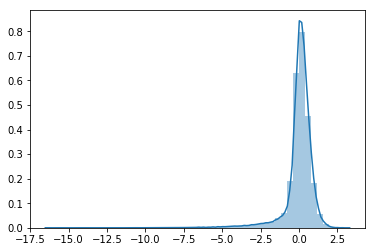

In [746]:
sns.distplot(X)
#sns.distplot(gen_seq)

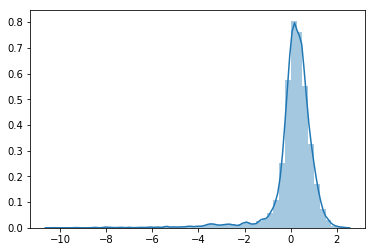

In [747]:
sns.distplot(gen_seq)

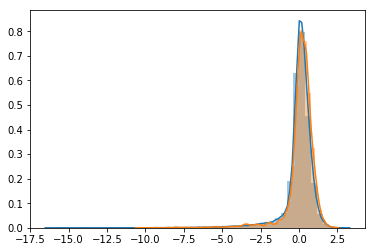

In [748]:
sns.distplot(X)
sns.distplot(gen_seq)

<Figure size 432x288 with 0 Axes>

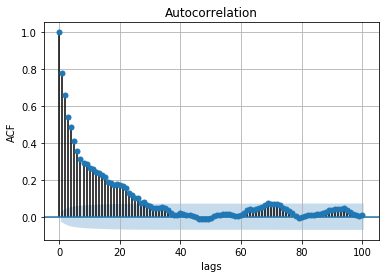

<Figure size 432x288 with 0 Axes>

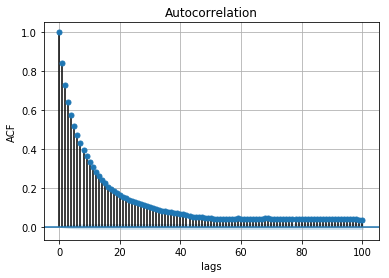

In [756]:
from statsmodels.graphics.tsaplots import plot_acf

plt.figure(3)
plot_acf(gen_seq, lags=100)
#plot_acf(samples[:,0], lags=50)
plt.xlabel('lags')
plt.ylabel('ACF')
plt.grid()
plt.show()


plt.figure(3)
#plot_acf(X[:1000], lags=100)
plot_acf(X, lags=100)
#plot_acf(samples[:,0], lags=50)
plt.xlabel('lags')
plt.ylabel('ACF')
plt.grid()
plt.show()

/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 14400 is greater than input length  = 1000, using nperseg = 1000
  .format(nperseg, input_length))
/usr/local/lib/python3.6/dist-packages/scipy/signal/spectral.py:1969: UserWarning: nperseg = 14400 is greater than input length  = 5000, using nperseg = 5000
  .format(nperseg, input_length))


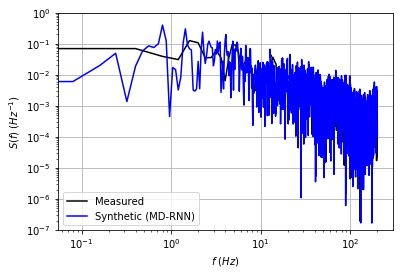

In [750]:
# Plot spectra
from scipy.signal import welch

sampling_rate = 400
nfft = 14400#10*14400
# Plot the scpectrum
def spectrum(data, nfft):
        x = data
        f,s = welch(x, sampling_rate, axis = 0, nperseg = nfft)
        return f,s

#f,s = spectrum(X[10000:15000])
f_90,s_90 = spectrum(X[:1000], nfft)
f_90_MDN,s_90_MDN = spectrum(gen_seq, nfft)

#fs_90 = [a*b for a,b in zip(f_90,s_90)]

#s_minusFiveThird = [i]

plt.figure(1)
plt.loglog(f_90,s_90, 'k', label = 'Measured')
#plt.loglog(f_90_HMM,s_90_HMM, 'r', label = 'Synthetic (HMM)')
plt.loglog(f_90_MDN,s_90_MDN, 'b', label = 'Synthetic (MD-RNN)')
#plt.loglog(f_90, 0.05*f_90**(-5/3), 'g', label = '-5/3 slope')
plt.ylim([1e-7,1e+0])
#plt.ylim([1e-5,1e-1])
#plt.xlim([1e-3,200])
plt.xlabel('$f\ (Hz)$')
plt.ylabel('$S(f)\  (Hz^{-1})$')
plt.legend()
plt.grid()
plt.show()


In [751]:
lkh

NameError: ignored

In [0]:
# Function to sample the next value given the model’s predictions
# sample the next value from a gaussian distribution whose mean, std and weight are calculated from the neural network output
def sample(preds, mu, sigma, pi, temperature=1.0):
    #preds: predictions from the LSTM output
    num_mix = 
    preds = np.asarray(preds).astype('float64')  
    select_mixture = np.random.choice(num_mix, p=pi[0])
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)  # Apply softmax to get probability values
    probas = np.random.normal(0, 1, 1)  # Draw samples from a Gaussian distribution with mean= and std= to be caluclated from the neural network output
    return np.argmax(probas)

Given a trained model and a seed sequence, we generate new sequence by repeatedly:

1) Drawing from the model a probability distribution over the next value given the sequence available so far

2) Reweighting the distribution to a certain "temperature"

3) Sampling the next value at random according to the reweighted distribution

4) Adding the new value at the end of the available sequence

In [0]:
import random
import sys

# Select a sequence seed at random (of length = maxlen)
start_index = random.randint(0, len(X) - maxlen - 1)
generated_sequence = X[start_index: start_index + maxlen] # This is actually the seed-sequence, from which longer sequences can be generated
#print('--- Generating with seed: ', generated_sequence )

sampled = np.zeros((1, maxlen, 1))


# run for 20 epochs
for epoch in range(1, 2):
    print('epoch', epoch)
    # Fit the model for 1 epoch on the available training data (Should I edit it such that it will continually change as new data are fed?)
    model.fit(np.array(x), np.array(y),
              batch_size=32,
              epochs=1)

    for temperature in [0.5]:#, 0.5, 1.0, 1.2]:
        print('------ temperature:', temperature)
        #print(generated_text)

        # We generate values for 400 time-steps, starting from the seed sequence
        for i in range(400):
            print(i)
            #sampled = np.zeros((1, maxlen, 1))
            for t, char in enumerate(generated_sequence):
                #print("t = ", t), print("char = ", char)
                sampled[0, t, :] = char#generated_text
            #print("sampled = ", sampled)
            preds = model.predict(sampled, verbose=1)
            #print("preds = ", preds)
            #print("np.shape(preds): ", np.shape(preds))
            preds = preds[0]
            #print("preds = ", preds)
            next_index = sample(preds, temperature)
            #print("next_index = ", next_index)
            next_val = X[next_index]
            #print("next_val = ", next_val)

            generated_text = np.append(generated_sequence,next_val) # Append the predicted value at the end
            #print("generated sequence = ", generated_sequence)
            generated_sequence = generated_sequence[1:]   # Remove the first element from the list
            #print("generated sequence = ", generated_sequence)

            #print(next_char)
            sys.stdout.flush()
        #print()
        
        print("generated_sequence = ", generated_sequence)